In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import os
import numpy as np
import linecache #fast access to a specific file line
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from einops import rearrange, repeat
import torch.nn.functional as F
import time
import torchinfo
from pathlib import Path

In [2]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

1.11.0
11.1
True


In [3]:
torch.multiprocessing.set_sharing_strategy('file_system') #to avoid issues in the dataloading
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
CONT_SIZE = 31

In [5]:
ALPHABET = ["A", "R", "N", "D", "C", "Q", "E", "G", "H", "I",
            "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]

ALPHABET = {ALPHABET[i]:i for i in range(len(ALPHABET))}

ALPHABET['-']= 20
ALPHABET['Z']= 21

print(ALPHABET)

{'A': 0, 'R': 1, 'N': 2, 'D': 3, 'C': 4, 'Q': 5, 'E': 6, 'G': 7, 'H': 8, 'I': 9, 'L': 10, 'K': 11, 'M': 12, 'F': 13, 'P': 14, 'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19, '-': 20, 'Z': 21}


In [6]:
#max 4
rep = torch.tensor([4, 4, 2, 1, 1, 1, 1, 1, 1, 1, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4])
rand = torch.tensor([0, 0, 0.2, 0, 0, 0, 0, 0, 0, 0.5, 0.7, 0, 0, 0, 0, 0, 0, 0,0, 0])
#max 8 
rep = torch.tensor([8, 8, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 5, 7, 8, 8, 8, 8, 8])
rand = torch.tensor([0, 0, 0.2, 0, 0, 0, 0, 0, 0.2, 0.5, 0.3, 0.9, 0.8, 0.5, 0.9, 0, 0, 0, 0, 0])

In [7]:
class MyDataset(Dataset):
    def __init__(self, data_dir, cont_size=6,div=2000,verbose=False):
        """
        Initialize the dataset by precomputing a bunch of data on the sequence families
        """
        self.col_size = 60 #number of column per file (Fasta standard)
        self.data_dir = data_dir #directory of the dataset
        self.cont_size = cont_size
        self.div = div
        self.len = 0  #number of families of sequences (1 per file)
        self.paths = {} #path of each families in the folder
        self.seq_lens = {} #length of each member of the family
        self.seq_nums = {} #number of member of the family
        self.aa_freqs = {} #frequencies of each symbol in the sequence family
        self.p_aa_freqs = {} #frequencies of each symbol in each sequence of a family
        
        
        dir_path = data_dir
        count = 0
        
        # Iterate directory
        for path in os.listdir(dir_path):
            # check if current path is a file
            temp_path = os.path.join(dir_path, path)
            if os.path.isfile(temp_path):
                n = 0 #number of sequences
                p = 0 # used to calculate the length of the sequences
                r = 0 # also used this way

                l = 0 # length of the seq l = p * self.col_size + r 

                cpt = 0 # to detect inconsistencies
                
                with open(temp_path, newline='') as f:
                    first_prot = True
                    newf = True
                    
                    aa_freq = torch.zeros(20)
                    p_aa_freq = torch.zeros(0)
                    
                    #parsing the file
                    line = f.readline()[:-1]
                    while line:
                        cpt += 1
                        if line[0] == '>': #header line
                            if not first_prot:
                                p_aa_freq = torch.cat([p_aa_freq,prot_aa_freq])
                            prot_aa_freq = torch.zeros(1,20)
                            n += 1
                            if newf and not first_prot:
                                newf = False
                            first_prot = False
                                
                        else:# sequence line
                            if newf and len(line) == self.col_size:
                                p += 1

                            if newf and len(line) != self.col_size:
                                r = len(line)
                            for aa in line:
                                aa_id = ALPHABET.get(aa,21)
                                if aa_id < 20:
                                    aa_freq[aa_id] += 1
                                    prot_aa_freq[0][aa_id] += 1

                            assert len(line) == self.col_size or len(line) == r
                        line = f.readline()[:-1]
                    
                    p_aa_freq = torch.cat([p_aa_freq,prot_aa_freq])
                    aa_freq = F.normalize(aa_freq,dim=0,p=1)
                    p_aa_freq = F.normalize(p_aa_freq,dim=1,p=1)

                l = p*self.col_size + r
                
                #sanity check
                #if the file line count is coherent with the number of sequences and their line count
                try: #if r != 0
                    assert (p+2) * n == cpt
                except: #if r == 0
                    assert (p+1) * n == cpt
                    assert r == 0
                    
                
                if n>1: #if this is false, we can't find pairs
                    self.paths[count] = path
                    self.seq_lens[count] = l
                    self.seq_nums[count] = n
                    self.aa_freqs[count] = aa_freq
                    self.p_aa_freqs[count] = p_aa_freq
                    count += 1
                    
                    if verbose and (count % 100 ==0) : print(f"seen = {count}")
            
        self.len = count
    
    def __len__(self):
        return self.len
     
    def sample(self, high, low=0, s=1):
        sample = np.random.choice(high-low, s, replace=False)
        return sample + low
    
    def __getitem__(self, idx, sample_size='auto',rep=rep,rand=rand): 
        """
        input idx of the family of the sample
        return a Tensor containing several samples from the family corresponding to the index
        """
        
        X = []
        y = []
        
        PIDs = []
        local_PIDs = []
        
        lengths = []
        
        pos = []
        
        bin_n = len(rep) #for biasing the sampling
        
        precomputed_pos = [] #positions of the amino-acids
        for i in range(-self.cont_size,self.cont_size+1):
            precomputed_pos.append(i)
        for i in range(-self.cont_size,0):
            precomputed_pos.append(i)
        for i in range(1,self.cont_size+1):
            precomputed_pos.append(i)
        
        precomputed_pos = torch.tensor(precomputed_pos).float()
        
        data_path = os.path.join(self.data_dir, self.paths[idx])
        try:
            n = self.seq_nums[idx]
            l = self.seq_lens[idx]
        except:
            print(idx)
            pass
        
        #sampling more for big families and long sequences
        if type(sample_size) != int:
            sample_s = min(n * l,25_000)
            coef = round((sample_s)/self.div) 
            sample_size = max(1,coef)
        
        p = l // self.col_size
        r = l % self.col_size # l = p * q + r
        sequence_line_count = p+2 if r else p+1

        for _ in range(sample_size):
            i,j = self.sample(n,s=2)

            start_i = 2 + (sequence_line_count)*i #start line of protein i
            start_j = 2 + (sequence_line_count)*j #start line of protein j
            
            seq_i = ''
            seq_j = ''
            
            PID_ij = 0
            
            l_ij = 0
            for offset in range(sequence_line_count-1): #computing PID and removing aligned '-' ##might need to compute the actual column num
                line_i = linecache.getline(data_path, (start_i + offset))[:-1]
                line_j = linecache.getline(data_path, (start_j + offset))[:-1]
                for aa_i, aa_j in zip(line_i,line_j):
                    if aa_i == aa_j:
                        if aa_i != '-':
                            PID_ij += 1
                            seq_i += aa_i
                            seq_j += aa_j        
                    else:
                        seq_i += aa_i
                        seq_j += aa_j
                    
                    if aa_j != '-' and aa_i != '-':
                        l_ij += 1
            
            try:
                PID_ij = PID_ij/l_ij
            except:
                PID_ij = 0 #case 0/0
            
            align_l = len(seq_i)
            possible_k = [] #possible position to take
            for k,(a_i,a_j) in enumerate(zip(seq_i,seq_j)):   
                if ALPHABET.get(a_i,21) < 20 and ALPHABET.get(a_j,21) < 20:
                    possible_k.append(k)
            
            # biasing for more diverse PID  
            bin_idx = int(PID_ij//(1/bin_n))
            rep_number = rep[bin_idx].clone()
            if torch.rand(1) < rand[bin_idx]:
                rep_number+=1
            
            for _ in range(rep_number):
                try:   
                    k = np.random.choice(possible_k)
                except:
                    continue
                
                #adding to the output
                lengths.append(align_l)
                pos_ij = (k + precomputed_pos)
                pos.append(pos_ij)
                
                #computing the windows
                window_i = ''
                window_j = ''
                for w in range(k-self.cont_size,k+self.cont_size+1):
                    if w < 0 or w >= align_l: #case of the edges
                        window_i += 'Z'
                        window_j += 'Z'
                    else:
                        window_i += seq_i[w]
                        window_j += seq_j[w]

                y_j = ALPHABET.get(window_j[self.cont_size], 21) # 'Z' is the default value for rare AA
                X_i = [ALPHABET.get(i, 21) for i in (window_i+window_j[:self.cont_size]+window_j[self.cont_size+1:])]       

                X.append(X_i)
                y.append(y_j)
                PIDs.append(PID_ij)
                #computing the local PID
                local_PID_ij = sum(1 for AA1,AA2 in zip(window_i, window_j[:self.cont_size]) if AA1 == AA2 and ALPHABET.get(AA1,21) < 20) \
                             + sum(1 for AA1,AA2 in zip(reversed(window_i), reversed(window_j[self.cont_size+1:])) if AA1 == AA2 and ALPHABET.get(AA1,21) < 20)

                loc_comp = sum(1 for AA1,AA2 in zip(window_i, window_j[:self.cont_size]) if ALPHABET.get(AA1,21) < 20 and ALPHABET.get(AA2,21) < 20) \
                             + sum(1 for AA1,AA2 in zip(reversed(window_i), reversed(window_j[self.cont_size+1:])) if ALPHABET.get(AA1,21) < 20 and ALPHABET.get(AA2,21) < 20)
                try:
                    tmp = local_PID_ij/loc_comp  
                except:
                    tmp = 0 #case 0/0

                local_PIDs.append(tmp)

                assert y_j < 20
                assert X_i[self.cont_size] < 20
            
        linecache.clearcache() #clearing the cache
        X = torch.tensor(X)
        try:
            X = F.one_hot(X,22)[:,:,0:-1]
        except RuntimeError:
            pass
        if len(pos) == 0:
            pos = torch.tensor(pos)
        else:
            pos = torch.stack(pos)

        X = X.float()
        y = torch.tensor(y)
        PIDs = torch.tensor(PIDs)
        local_PIDs = torch.tensor(local_PIDs)
        lengths = torch.tensor(lengths)
        out = X,y.long(),PIDs,local_PIDs,pos,lengths
        return out


In [8]:
#Run This for new data
"""
train_dataset = MyDataset(r"data/train_data",cont_size = 6,4000)
test_dataset = MyDataset(r"data/test_data",cont_size = 6,div=2000)
val_dataset = MyDataset(r"data/val_data",cont_size = 6,div=2000)

fname = 'data/train_dataset1.pth'
savepath = Path(fname)
with savepath.open("wb") as fp:
    torch.save(train_dataset,fp)
    
fname = 'data/test_dataset1.pth'
savepath = Path(fname)
with savepath.open("wb") as fp:
    torch.save(test_dataset,fp)
    
fname = 'data/val_dataset1.pth'
savepath = Path(fname)
with savepath.open("wb") as fp:
    torch.save(val_dataset,fp)
"""

'\ntrain_dataset = MyDataset(r"data/train_data",cont_size = 6,4000)\ntest_dataset = MyDataset(r"data/test_data",cont_size = 6,div=2000)\nval_dataset = MyDataset(r"data/val_data",cont_size = 6,div=2000)\n\nfname = \'data/train_dataset1.pth\'\nsavepath = Path(fname)\nwith savepath.open("wb") as fp:\n    torch.save(train_dataset,fp)\n    \nfname = \'data/test_dataset1.pth\'\nsavepath = Path(fname)\nwith savepath.open("wb") as fp:\n    torch.save(test_dataset,fp)\n    \nfname = \'data/val_dataset1.pth\'\nsavepath = Path(fname)\nwith savepath.open("wb") as fp:\n    torch.save(val_dataset,fp)\n'

In [9]:
#To load datasets with all features computed
fname = 'data/train_dataset1.pth'
savepath = Path(fname)
with savepath.open("rb") as fp:
    train_dataset = torch.load(fp)
    
fname = 'data/test_dataset1.pth'
savepath = Path(fname)
with savepath.open("rb") as fp:
    test_dataset = torch.load(fp)
    
fname = 'data/val_dataset1.pth'
savepath = Path(fname)
with savepath.open("rb") as fp:
    val_dataset = torch.load(fp)
    
print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

train_dataset.cont_size = CONT_SIZE
test_dataset.cont_size = CONT_SIZE
val_dataset.cont_size = CONT_SIZE

train_dataset.div = 2000
test_dataset.div = 2000
val_dataset.div = 2000

13219
2838
2826


In [10]:
def my_collate(batch):
    """
    Transforms a list of tensors to a batch tensor
    """
    data = torch.cat([item[0] for item in batch],dim=0)
    target = torch.cat([item[1] for item in batch],dim=0)
    PID = torch.cat([item[2] for item in batch],dim=0)
    lPID = torch.cat([item[3] for item in batch],dim=0)
    pos = torch.cat([item[4] for item in batch],dim=0)
    length = torch.cat([item[5] for item in batch],dim=0)
    return data, target, PID, lPID, pos, length

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True,collate_fn=my_collate,num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True,collate_fn=my_collate,num_workers=4)

val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True,collate_fn=my_collate,num_workers=4)

In [12]:
class AttBlock(nn.Module):
    """
    Self-Attention Block of the Transformer
    """
    def __init__(self,in_features,out_features=None,num_heads=8,head_dims=24):
        super().__init__()
        out_features = out_features or in_features
        
        self.Q_w = nn.Linear(in_features,num_heads*head_dims,bias=False)
        self.K_w = nn.Linear(in_features,num_heads*head_dims,bias=False)
        self.V_w = nn.Linear(in_features,num_heads*head_dims,bias=False)
        
        self.att = nn.MultiheadAttention(num_heads*head_dims,num_heads=num_heads,batch_first=True)
        self.lin = nn.Linear(num_heads*head_dims,out_features)
        
    def forward(self,x):
        Q = self.Q_w(x)
        K = self.K_w(x)
        V = self.V_w(x)
        out,_ = self.att(Q,K,V,need_weights=False)
        out = self.lin(out)
        
        return out

In [13]:
class CrossAttBlock(nn.Module):
    """
    Cross-Attention Block of the Transformer
    """
    def __init__(self,in_features,out_features=None,num_heads=8,head_dims=24):
        super().__init__()
        out_features = out_features or in_features
        
        self.Q_w_tgt = nn.Linear(in_features,num_heads*head_dims,bias=False)
        self.K_w_src = nn.Linear(in_features,num_heads*head_dims,bias=False)
        self.V_w_src = nn.Linear(in_features,num_heads*head_dims,bias=False)
        
        self.att_tgt = nn.MultiheadAttention(num_heads*head_dims,num_heads=num_heads,batch_first=True)
        
        self.lin = nn.Linear(num_heads*head_dims,out_features)
        
    def forward(self,x):
        src,tgt = x[:,0],x[:,1]
        
        Q_tgt = self.Q_w_tgt(tgt)
        K_src = self.K_w_src(src)
        V_src = self.V_w_src(src)
        
        out,_ = self.att_tgt(Q_tgt,K_src,V_src,need_weights=False)
        out = self.lin(out)
        
        return out

In [14]:
class CrossAttQBlock(nn.Module):
    """
    Cross-Attention Block of the Transformer
    """
    def __init__(self,in_features,out_features=None,num_heads=8,head_dims=24):
        super().__init__()
        out_features = out_features or in_features
        
        self.Q_w_Q = nn.Linear(20,num_heads*head_dims,bias=False)
        self.K_w_x = nn.Linear(in_features,num_heads*head_dims,bias=False)
        self.V_w_x = nn.Linear(in_features,num_heads*head_dims,bias=False)
        
        self.att_tgt = nn.MultiheadAttention(num_heads*head_dims,num_heads=num_heads,batch_first=True)

        self.lin = nn.Linear(num_heads*head_dims,20)
        
    def forward(self,x,Q):
        
        Q_Q = self.Q_w_Q(Q)
        K_x = self.K_w_x(x)
        V_x = self.V_w_x(x)
        
        out,_ = self.att_tgt(Q_Q,K_x,V_x,need_weights=False)
        out = self.lin(out)
        
        return out

In [15]:
class LastCrossAttBlock(nn.Module):
    """
    Cross-Attention Block of the Transformer
    """
    def __init__(self,in_features,out_features=None,num_heads=8,head_dims=24):
        super().__init__()
        out_features = out_features or in_features
        
        self.Q_w = nn.Linear(in_features,num_heads*head_dims,bias=False)
        self.K_w = nn.Linear(in_features,num_heads*head_dims,bias=False)
        self.V_w = nn.Linear(in_features,num_heads*head_dims,bias=False)
        
        self.att = nn.MultiheadAttention(num_heads*head_dims,num_heads=num_heads,batch_first=True)
        self.lin = nn.Linear(num_heads*head_dims,out_features)
        
    def forward(self,x):
        src,tgt = x[:,0],x[:,1]
        Q = self.Q_w(tgt)
        K = self.K_w(src)
        V = self.V_w(src)
        out,_ = self.att(Q,K,V,need_weights=False)
        out = self.lin(out)
        
        return out

In [16]:
class RowAttBlock(nn.Module):
    """
    Row-wise Attention Block
    """
    def __init__(self,in_features,out_features=None,num_heads=8,head_dims=24):
        super().__init__()
        self.att_block = AttBlock(in_features,num_heads=num_heads,head_dims=head_dims)
    
    def forward(self,x):
        b,n,l,d = x.shape
        out = self.att_block(x.view((b*n,l,d))).view(b,n,l,d)
        return out
    
class ColAttBlock(nn.Module):
    """
    Column-wise Attention Block
    """
    def __init__(self,in_features,out_features=None,num_heads=8,head_dims=24):
        super().__init__()
        self.att_block = AttBlock(in_features,num_heads=num_heads,head_dims=head_dims)
    
    def forward(self,x):
        b,n,l,d = x.shape
        out = self.att_block(x.view((b*l,n,d))).view((b,n,l,d))
        return out

In [17]:
class FeedFoward2D(nn.Module):
    """
    MLP Block of the Transformer
    """    
    def __init__(self,in_features,out_features=None,wide_factor=4):
        super().__init__()
        out_features = out_features or 2*in_features
        hidden_dim = wide_factor * 2*in_features
        
        self.lin1 = nn.Linear(2*in_features,hidden_dim)
        self.act1 = nn.GELU()
        self.lin2 = nn.Linear(hidden_dim,out_features)
        self.act2 = nn.GELU()
        
    def forward(self,x):
        b,n,l,d = x.shape
        
        #dst = src.transpose(1, 2).reshape(b,l,n*d)
        #src = dst.reshape(b,l,n,d).transpose(1,2)

        out = x.transpose(1, 2).reshape(b,l,n*d)
        out = self.lin1(out)
        out = self.act1(out)
        out = self.lin2(out)
        out = self.act2(out)
        out = out.reshape(b,l,-1,d).transpose(1,2)
        return out

In [18]:
class FeedFoward(nn.Module):
    """
    MLP Block of the Transformer
    """    
    def __init__(self,in_features,out_features=None,wide_factor=4,act2 = None):
        super().__init__()
        out_features = out_features or in_features
        hidden_dim = wide_factor * in_features
        
        self.lin1 = nn.Linear(in_features,hidden_dim)
        self.act1 = nn.GELU()
        self.lin2 = nn.Linear(hidden_dim,out_features)
        self.act2 = act2 or nn.GELU()
        
    def forward(self,x):
        out = self.lin1(x)
        out = self.act1(out)
        out = self.lin2(out)
        out = self.act2(out)
        
        return out

In [19]:
#(from the timm library)
def drop_path(x, drop_prob: float = 0.1, training: bool = False, scale_by_keep: bool = True):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).

    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.

    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = x.new_empty(shape).bernoulli_(keep_prob)
    if keep_prob > 0.0 and scale_by_keep:
        random_tensor.div_(keep_prob)
    return x * random_tensor


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None, scale_by_keep=True):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob
        self.scale_by_keep = scale_by_keep

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training, self.scale_by_keep)


In [20]:
class Block(nn.Module):
    """
    Basic Block of the Transformer
    """
    def __init__(self,in_features,num_heads=8,head_dims=24,wide_factor=4,drop=0.1):
        super().__init__()
        
        self.row_att_block = RowAttBlock(in_features,num_heads=num_heads,head_dims=head_dims)
        self.ff2d = FeedFoward2D(in_features,wide_factor=wide_factor)
        self.drop_path = DropPath(drop)
        
        self.norm1 = nn.LayerNorm(in_features)
        self.norm2 = nn.LayerNorm(in_features)
        
    def forward(self,x):
        out = x + self.drop_path(self.row_att_block(x))
        out = self.norm1(out)
        out = out + self.drop_path(self.ff2d(out))
        out = self.norm2(out)
        
        return out

In [21]:
class LastBlock(nn.Module):
    """
    Last Block of the Transformer
    """
    def __init__(self,in_features,num_heads=8,head_dims=24,wide_factor=4,drop=0.1):
        super().__init__()
        
        self.row_att_block = RowAttBlock(in_features,num_heads=num_heads,head_dims=head_dims)
        self.ff = FeedFoward(in_features,wide_factor=wide_factor)
        self.cross_att_block = CrossAttBlock(in_features,num_heads=num_heads,head_dims=head_dims)
        self.ff2 = FeedFoward(in_features,wide_factor=wide_factor)
        self.drop_path = DropPath(drop)
        
        self.norm1 = nn.LayerNorm(in_features)
        self.norm2 = nn.LayerNorm(in_features)
        self.norm3 = nn.LayerNorm(in_features)
        self.norm4 = nn.LayerNorm(in_features)
        
    def forward(self,x):
        out = x + self.drop_path(self.row_att_block(x))
        out = self.norm1(out)
        out = out + self.drop_path(self.ff(out))
        out = self.norm2(out)
        out = out[:,1] + self.drop_path(self.cross_att_block(out))
        out = self.norm3(out)
        out = out + self.drop_path(self.ff2(out))
        return out

ADD Linear + Act d-wise before clf_head

In [22]:
class Q_block(nn.Module):
    def __init__(self,in_features,num_heads=8,head_dims=24):
        super().__init__()
        self.cross_att_q_block = CrossAttQBlock(in_features,num_heads=num_heads,head_dims=head_dims)
        self.cross_att_block = CrossAttBlock(in_features,num_heads=num_heads,head_dims=head_dims)
        self.act = torch.nn.Softplus()
    def forward(self,x,Q):
        x = x[:,1] + self.cross_att_block(x)
        Q = Q + self.cross_att_q_block(x,Q)
        
        Q = self.act(Q) #so that every element of Q is >=0
        
        PI = torch.diagonal(Q,dim1=-2,dim2=-1).clone() #makes a copy of the diagonal
        PI = F.normalize(PI,p=1,dim=1)  # and normalize it to make probabilities
        
        #pointer manipulation
        tmp = torch.diagonal(Q,dim1=-2,dim2=-1) 
        tmp -= tmp #set Q diagonal to 0
        tmp -= torch.sum(Q,dim=2) #sum over rows = 0
        
        mu = -(PI*torch.diagonal(Q,dim1=-2,dim2=-1)).sum(dim=1).view(-1,1,1) #normalization factor
        Q = Q/mu
        return Q
        
        
        

In [23]:
class Classifier_Head(nn.Module):
    """
    Classifier Head of the Transformer
    """
    def __init__(self,in_features,clf_dims,out_size,seq_len):
        super().__init__()
        in_dim = seq_len*in_features
        self.in_dim = in_dim
        
        layers = []
        for out_dim in clf_dims:
            layers.append(nn.Linear(in_dim,out_dim))
            layers.append(nn.GELU())
            layers.append(nn.Dropout(p=0.2))
            in_dim = out_dim

        layers.append(nn.Linear(in_dim,out_size))
        layers.append(nn.Softplus())
        
        self.clf = nn.Sequential(*layers)
        
    def forward(self,x):
        out = x.view((-1,self.in_dim))
        
        out = self.clf(out)
        
        return out

In [24]:
def get_params(input_size,N,head,head_dim,wide_factor,drop_prob):
    """
    Returns the initialization parameters of the Transformer
    """
    return input_size, [head for _ in range(N)], [head_dim for _ in range(N)], [wide_factor for _ in range(N)], [drop_prob for _ in range(N)], 

In [34]:
class AttNet(nn.Module):
    """
    Transformer-like neural net
    """
    def __init__(self,in_features,num_heads,head_dims,wide_factors,drops,input_dim=21,out_size=20,num_seq=2,seq_len=2*CONT_SIZE+2,clf_dims=[256,64],cont_size=CONT_SIZE):
        super().__init__()
        self.in_features = in_features
        self.input_dim = input_dim
        self.cont_size=cont_size
        self.seq_len = seq_len
        
        blocks = []
        r = min(len(num_heads),len(head_dims),len(wide_factors),len(drops))
        for i,(n_h, h_d,w,d) in enumerate(zip(num_heads,head_dims,wide_factors,drops)):
            blocks.append(Block(in_features,num_heads=n_h,head_dims=h_d,wide_factor=w,drop=d))
            
        self.feature_extractor = nn.Sequential(*blocks)
        
        self.dist = Classifier_Head(in_features,clf_dims,out_size=1,seq_len=seq_len)
        
        sp = Path("data/freq.pth")
        with sp.open("rb") as fp:
            self.F = nn.Parameter(torch.log(torch.load(fp)))
            
        pid_layers = [nn.Linear(1,2*in_features),nn.Sigmoid()]
        self.pid_l = nn.Sequential(*pid_layers)
        
        self.Qp = nn.Parameter(torch.randn(20,20))
        self.Q_b = Q_block(in_features)
        
        self.dist_feature_ext = FeedFoward2D(in_features,in_features,wide_factor=2)
        
        self.X_Q = FeedFoward(seq_len,out_features=1)
        self.X_Q2 = FeedFoward(in_features,out_features=20,act2=nn.Identity())
        
    def to_input(self,x,PID,pos,length):
        X_idx = torch.argmax(x[:,self.cont_size],dim=1)
        seq1 = x[:,:2*self.cont_size+1]
        y_freq = F.pad(F.softmax(self.F[X_idx],dim=1).unsqueeze(1), pad=(0, 1), mode='constant', value=0) 
        seq2 = torch.cat((x[:,2*self.cont_size+1:3*self.cont_size+1],y_freq,x[:,3*self.cont_size+1:]),dim=1)
        aa_pos = pos[:,:2*self.cont_size+1]/length.unsqueeze(1)
        aa_pos = aa_pos.unsqueeze(2)
        pos_dim = (self.in_features-self.input_dim-1)//2
        
        for i in range(pos_dim): #positionnal_encoding
            p = torch.cos(pos[:,:2*self.cont_size+1]/(32**(2*i/pos_dim))).unsqueeze(2)
            ip = torch.sin(pos[:,:2*self.cont_size+1]/(32**(2*i/pos_dim))).unsqueeze(2)
            aa_pos = torch.cat([aa_pos,p,ip],dim=2)
        
        seq1 = torch.cat([seq1,aa_pos],dim=2)
        seq2 = torch.cat([seq2,aa_pos],dim=2)
        
        out = torch.stack([seq1,seq2],dim=1)
        
        pid = self.pid_l(PID.unsqueeze(1)).unsqueeze(1)
        pid = rearrange(pid,"b 1 (n e) -> b n 1 e",n=2)
        
        out = torch.cat([out,pid],dim=2)
        
        return out
        
        
    def forward(self,x,PID,pos,length):
        X_input = self.to_input(x,PID,pos,length)
        b = X_input.shape[0]
        Q = repeat(self.Qp,"c d -> b c d",b=b)
        features = self.feature_extractor(X_input)
        dist_features = self.dist_feature_ext(features)
        X_pred = self.X_Q(features[:,0].view(-1,self.in_features,self.seq_len))
        X_pred = self.X_Q2(X_pred.view(-1,self.in_features))
        X_pred = F.softmax(X_pred,dim=1).unsqueeze(1)
        t = self.dist(dist_features)
        Q = self.Q_b(features,Q)
        y_pred = (X_pred @ torch.matrix_exp(Q*t.view(-1,1,1))).view(-1,20)
        return y_pred

In [35]:
class State:
    """
    Used for checkpointing
    """
    def __init__(self,model,optim,scheduler):
        self.model = model
        self.optim = optim
        self.scheduler = scheduler
        self.epoch = 0

In [36]:
params = get_params(32,6,8,32,4,0.1)
model = AttNet(*params,clf_dims=[512,128,32])
torchinfo.summary(model,[(1,4*CONT_SIZE+1,21),(1,),(1,4*CONT_SIZE+1),(1,)])

Layer (type:depth-idx)                             Output Shape              Param #
AttNet                                             [1, 20]                   800
├─Sequential: 1-1                                  [1, 64]                   --
│    └─Linear: 2-1                                 [1, 64]                   128
│    └─Sigmoid: 2-2                                [1, 64]                   --
├─Sequential: 1-2                                  [1, 2, 64, 32]            --
│    └─Block: 2-3                                  [1, 2, 64, 32]            --
│    │    └─RowAttBlock: 3-1                       [1, 2, 64, 32]            295,968
│    │    └─DropPath: 3-2                          [1, 2, 64, 32]            --
│    │    └─LayerNorm: 3-3                         [1, 2, 64, 32]            64
│    │    └─FeedFoward2D: 3-4                      [1, 2, 64, 32]            33,088
│    │    └─DropPath: 3-5                          [1, 2, 64, 32]            --
│    │    └─LayerNorm: 3

In [37]:
def eval_model(fname,train,test,val,N=10):
    """
    Evaluate the MSE (Brier Score) of the model
    """
    savepath = Path(fname)
    with savepath.open("rb") as fp:
        state = torch.load(fp)
        
    state.model.eval()
    with torch.no_grad():
        print('EVALUATING ON TRAIN DATA : ')
        eval_losses = []
        for _ in range(N):
            for X,y, PID, lPID,pos,length in train:
                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                pos = pos.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pos,length)

                y = F.one_hot(y, 20)
                eval_l = (y_hat-y)**2
                eval_losses.append(torch.sum(eval_l,dim=1).detach().cpu())

        score_train = torch.mean(torch.cat(eval_losses)).detach().cpu().item()
        print(f"{score_train = }\n")

        print('EVALUATING ON TEST DATA : ')
        eval_losses = []
        for _ in range(N):
            for X,y, PID, lPID, pos,length in test:
                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                pos = pos.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pos,length)

                y = F.one_hot(y, 20)
                eval_l = (y_hat-y)**2
                eval_losses.append(torch.sum(eval_l,dim=1).detach().cpu())
    
        score_test = torch.mean(torch.cat(eval_losses)).detach().cpu().item()
        print(f"{score_test = }\n")

        print('EVALUATING ON VAL DATA : ')
        eval_losses = []
        for _ in range(N):
            for X,y, PID, lPID,pos, length in val:
                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                pos = pos.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pos,length)

                y = F.one_hot(y, 20)
                eval_l = (y_hat-y)**2
                eval_losses.append(torch.sum(eval_l,dim=1).detach().cpu())
    
        score_val = torch.mean(torch.cat(eval_losses)).detach().cpu().item()
        print(f"{score_val = }\n")
    
    return score_train, score_test, score_val

In [38]:
def eval_model_PID(fname,train,test,val,N=10):
    """
    Evaluate the MSE (Brier Score) of the model for different slices of PID in the data
    """
    savepath = Path(fname)
    with savepath.open("rb") as fp:
        state = torch.load(fp)
    bin_n = 20
    state.model.eval()
    with torch.no_grad():
        print('EVALUATING ON TRAIN DATA : ')
        eval_losses = []
        PIDS = []
        for _ in range(N):
            for X,y, PID, lPID,pos,length in train:
                PIDS.append(PID)
  
                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                pos = pos.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pos,length)

                y = F.one_hot(y, 20)
                eval_l = (y_hat-y)**2
                eval_losses.append(torch.sum(eval_l,dim=1).detach().cpu())
        PIDS = torch.cat(PIDS)
        BINS = (PIDS/(1/bin_n)).long()
        scores = torch.cat(eval_losses).detach().cpu()
        
        Losses_train = torch.zeros(bin_n)
        bar_train = torch.zeros(bin_n)
        for i,n in zip(BINS,scores):
            bar_train[i] += 1
            Losses_train[i] += n
        Losses_train = Losses_train/bar_train
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),Losses_train,width=1/(bin_n+1))
        plt.title("Brier Score wrt PID on Train dataset")
        plt.show()
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),bar_train,width=1/(bin_n+1))
        plt.title("Example count wrt PID on Train dataset")
        plt.show()
        
        print('EVALUATING ON TEST DATA : ')
        eval_losses = []
        PIDS = []
        for _ in range(N):
            for X,y, PID, lPID,pos,length in test:
                PIDS.append(PID)
  
                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                pos = pos.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pos,length)

                y = F.one_hot(y, 20)
                eval_l = (y_hat-y)**2
                eval_losses.append(torch.sum(eval_l,dim=1).detach().cpu())
        PIDS = torch.cat(PIDS)
        BINS = (PIDS/(1/bin_n)).long()
        scores = torch.cat(eval_losses).detach().cpu()
        
        Losses_test = torch.zeros(bin_n)
        bar_test = torch.zeros(bin_n)
        for i,n in zip(BINS,scores):
            bar_test[i] += 1
            Losses_test[i] += n
        Losses_test = Losses_test/bar_test
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),Losses_test,width=1/(bin_n+1))
        plt.title("Brier Score wrt PID on Test dataset")
        plt.show()
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),bar_test,width=1/(bin_n+1))
        plt.title("Example count wrt PID on Test dataset")
        plt.show()
        
        print('EVALUATING ON VAL DATA : ')
        eval_losses = []
        PIDS = []
        for _ in range(N):
            for X,y, PID, lPID,pos,length in val:
                PIDS.append(PID)
  
                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                pos = pos.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pos,length)

                y = F.one_hot(y, 20)
                eval_l = (y_hat-y)**2
                eval_losses.append(torch.sum(eval_l,dim=1).detach().cpu())
        PIDS = torch.cat(PIDS)
        BINS = (PIDS/(1/bin_n)).long()
        scores = torch.cat(eval_losses).detach().cpu()
        
        Losses_val = torch.zeros(bin_n)
        bar_val = torch.zeros(bin_n)
        for i,n in zip(BINS,scores):
            bar_val[i] += 1
            Losses_val[i] += n
        Losses_val = Losses_val/bar_val
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),Losses_val,width=1/(bin_n+1))
        plt.title("Brier Score wrt PID on Val dataset")
        plt.show()
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),bar_val,width=1/(bin_n+1))
        plt.title("Example count wrt PID on Val dataset")
        plt.show()
        
    return Losses_train, bar_train, Losses_test, bar_test, Losses_val,bar_val

In [39]:
def eval_model_acc_PID(fname,train,test,val,N=10):
    """
    Evaluate the accuracy of the model for different slices of PID in the data
    """
    savepath = Path(fname)
    with savepath.open("rb") as fp:
        state = torch.load(fp)
    bin_n = 20
    state.model.eval()
    with torch.no_grad():
        print('EVALUATING ON TRAIN DATA : ')
        eval_losses = []
        PIDS = []
        for _ in range(N):
            for X,y, PID, lPID,pos,length in train:
                PIDS.append(PID)
  
                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                pos = pos.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pos,length)
                y_hat = torch.argmax(y_hat,dim=1)

                eval_l = (y == y_hat).long()
                eval_losses.append(eval_l.detach().cpu())
                
        PIDS = torch.cat(PIDS)
        BINS = (PIDS/(1/bin_n)).long()
        scores = torch.cat(eval_losses).detach().cpu()
        
        Losses_train = torch.zeros(bin_n)
        bar_train = torch.zeros(bin_n)
        for i,n in zip(BINS,scores):
            bar_train[i] += 1
            Losses_train[i] += n
        Losses_train = Losses_train/bar_train
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),Losses_train,width=1/(bin_n+1))
        plt.title("Accuracy wrt PID on Train dataset")
        plt.show()
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),bar_train,width=1/(bin_n+1))
        plt.title("Example count wrt PID on Train dataset")
        plt.show()
        
        print('EVALUATING ON TEST DATA : ')
        eval_losses = []
        PIDS = []
        for _ in range(N):
            for X,y, PID, lPID,pos,length in test:
                PIDS.append(PID)
  
                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                pos = pos.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pos,length)
                y_hat = torch.argmax(y_hat,dim=1)

                eval_l = (y == y_hat).long()
                eval_losses.append(eval_l.detach().cpu())
        PIDS = torch.cat(PIDS)
        BINS = (PIDS/(1/bin_n)).long()
        scores = torch.cat(eval_losses).detach().cpu()
        
        Losses_test = torch.zeros(bin_n)
        bar_test = torch.zeros(bin_n)
        for i,n in zip(BINS,scores):
            bar_test[i] += 1
            Losses_test[i] += n
        Losses_test = Losses_test/bar_test
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),Losses_test,width=1/(bin_n+1))
        plt.title("Accuracy wrt PID on Test dataset")
        plt.show()
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),bar_test,width=1/(bin_n+1))
        plt.title("Example count wrt PID on Test dataset")
        plt.show()
        
        print('EVALUATING ON VAL DATA : ')
        eval_losses = []
        PIDS = []
        for _ in range(N):
            for X,y, PID,lPID,pos,length in val:
                PIDS.append(PID)
  
                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                pos = pos.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pos,length)
                y_hat = torch.argmax(y_hat,dim=1)

                eval_l = (y == y_hat).long()
                eval_losses.append(eval_l.detach().cpu())
        PIDS = torch.cat(PIDS)
        BINS = (PIDS/(1/bin_n)).long()
        scores = torch.cat(eval_losses).detach().cpu()
        
        Losses_val = torch.zeros(bin_n)
        bar_val = torch.zeros(bin_n)
        for i,n in zip(BINS,scores):
            bar_val[i] += 1
            Losses_val[i] += n
        Losses_val = Losses_val/bar_val
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),Losses_val,width=1/(bin_n+1))
        plt.title("Accuracy wrt PID on Val dataset")
        plt.show()
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),bar_val,width=1/(bin_n+1))
        plt.title("Example count wrt PID on Val dataset")
        plt.show()
        
    return Losses_train, bar_train, Losses_test, bar_test, Losses_val,bar_val

In [40]:
def main(train_loader,val_loader,epochs=101,fname="models/state.pth",fnameb=None,state=None,last_epoch_sched=float('inf'),use_mut=True,cont_size=CONT_SIZE):
    """
    Trains a model
    """
    #to get the best model
    best = float('inf')
    
    #getting the acceleration device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    #loading from previous checkpoint
    if fnameb is None:
        fnameb = fname[:-4] + '_best' +fname[-4:]
        
    savepath = Path(fname)
    if savepath.is_file():
        with savepath.open("rb") as fp:
            state = torch.load(fp)
    else:
        if state is None:
            model = AttNet(22,[8,8,8],[24,24,24],[4,4,4],[0.1,0.1,0.1])
            model = model.to(device)
            optim = torch.optim.AdamW(model.parameters(),lr = 0.0001)
            scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optim,16,2)
            state = State(model,optim,scheduler)
    
    
    Loss = nn.NLLLoss(reduction='sum')
    
    #for logs
    List_Loss = []
    Eval_Loss = []
    for epoch in range(state.epoch, epochs):
        batch_losses = []
        state.model.train()
        for X,y, PID, lPID,pos,length in train_loader:
            X = X.to(device)
            y = y.to(device)
            PID = PID.to(device)
            pos = pos.to(device)
            length = length.to(device)
            
            state.optim.zero_grad()
            y_hat = state.model(X,PID,pos,length)
            l = Loss(torch.log(y_hat),y)/440 
            l.backward()
            state.optim.step()
            
            
            
            batch_losses.append(l.detach().cpu())
        List_Loss.append(torch.mean(torch.stack(batch_losses)).detach().cpu())
        state.epoch = epoch + 1
        if epoch < last_epoch_sched:
            state.scheduler.step()
        
        savepath = Path(fname)
        with savepath.open("wb") as fp:
            torch.save(state,fp)
        
        with torch.no_grad():
            eval_losses = [] 
            state.model.eval()
            for X,y, PID, lPID, pos,length in val_loader:

                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                pos = pos.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pos,length)

                y = F.one_hot(y, 20)
                eval_l = (y_hat-y)**2
                eval_losses.append(torch.sum(eval_l,dim=1).detach().cpu())
    
            score = torch.mean(torch.cat(eval_losses)).detach().cpu().item()
            Eval_Loss.append(score)
        
        if score < best :
            best = score
            savepath = Path(fnameb)
            with savepath.open("wb") as fp:
                torch.save(state,fp)
        
        print(f"epoch n°{epoch} : train_loss = {List_Loss[-1]}, val_loss = {Eval_Loss[-1]}") 


        
    return List_Loss,Eval_Loss,state

In [47]:
!rm "models/state_Q_mat_fixed.pth"

In [ ]:
params = get_params(32,5,8,32,4,0.2)
model = AttNet(*params,clf_dims=[512,128,32])
model = model.to(device)
optim = torch.optim.AdamW(model.parameters(),lr = 0.0003)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optim,16,2)
state = State(model,optim,scheduler)

fname = "models/state_Q_mat_fixed.pth" 
start = time.time()

Train,Eval,_ = main(train_dataloader, val_dataloader,fname=fname,epochs=2032,state=state,use_mut=False)
stop = time.time()
print(stop-start)

epoch n°0 : train_loss = 2.909058094024658, val_loss = 0.9406532049179077
epoch n°1 : train_loss = 2.8894128799438477, val_loss = 0.9410019516944885
epoch n°2 : train_loss = 2.8809618949890137, val_loss = 0.9307694435119629
epoch n°3 : train_loss = 2.649827718734741, val_loss = 0.8746313452720642


In [ ]:
plt.plot(np.arange(len(Train)),Train)

In [ ]:
plt.plot(np.arange(len(Eval)),Eval)

In [ ]:
N = 10 #moving average
smothed_Eval = np.convolve(Eval, np.ones(N)/N, mode='valid')
plt.plot(np.arange(len(smothed_Eval)),smothed_Eval)

In [ ]:

SCORES = eval_model(fname,train_dataloader,test_dataloader,val_dataloader)

In [ ]:

SCORES = eval_model_PID(fname,train_dataloader,test_dataloader,val_dataloader)

In [ ]:

SCORES = eval_model_acc_PID(fname,train_dataloader,test_dataloader,val_dataloader)

In [75]:

savepath = Path(fname)
with savepath.open("rb") as fp:
    model = torch.load(fp).model.to('cpu').eval()

In [153]:
for X,y,PID,lPID,pos,length in test_dataloader:
    break

In [154]:
X_input = model.to_input(X,PID,pos,length)

In [158]:
X.shape

torch.Size([420, 125, 21])

In [156]:
idx = 42
L = [X_input.detach().cpu()]
x = X_input
for i,f in model.feature_extractor.named_children():
    x = f(x)
    L.append(x.detach().cpu())

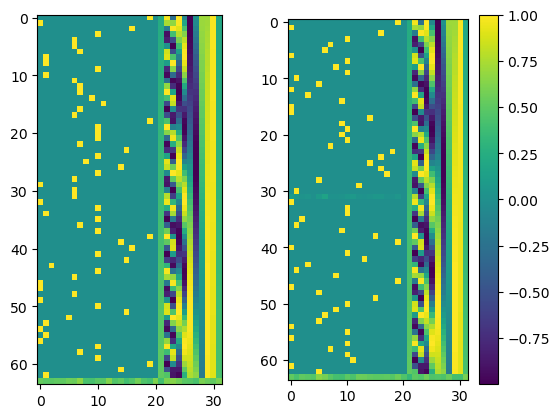

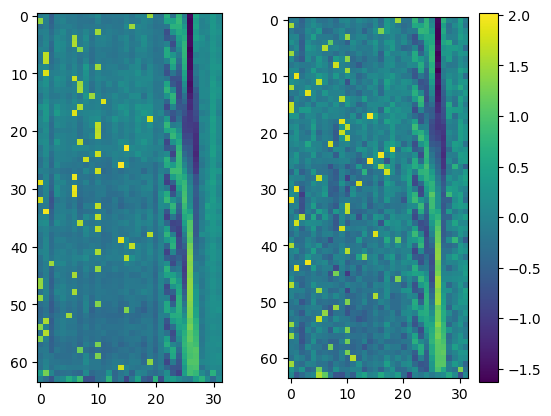

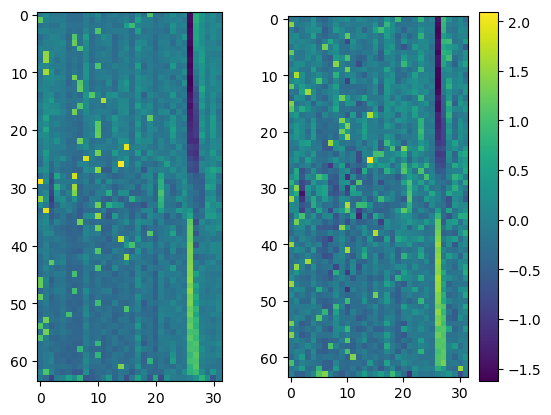

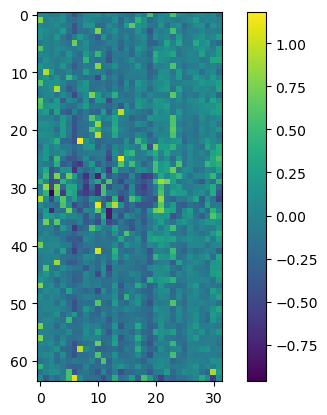

In [157]:
for X_im in L[:-1]:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    im = ax1.imshow(X_im[idx][0])
    im = ax2.imshow(X_im[idx][1])
    fig.colorbar(im)
    plt.show()

plt.imshow(L[-1][idx])
plt.colorbar()
plt.show()

In [159]:
b = X_input.shape[0]
Q = repeat(model.Qp,"c d -> b c d",b=b)
features = L[-1]
t = model.dist(features)
Q = model.Q_b(features,Q)
y_pred = (X[:,31,:20].unsqueeze(1) @ torch.matrix_exp(Q*t.view(-1,1,1))).squeeze(1)

In [161]:
(y_pred == (torch.matrix_exp(Q*t.view(-1,1,1))*x_aa).sum(dim=1)).all()

tensor(True)

In [184]:
(torch.matrix_exp(Q*t.view(-1,1,1))*x_aa).shape

torch.Size([420, 20, 20])

In [ ]:
(y_pred == (torch.matrix_exp(Q*t.view(-1,1,1)) @ (X[:,31,:20]).T).sum(dim=1)).all()

In [205]:
y_pred == 

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [194]:
y_pred

tensor([[0.0605, 0.0645, 0.0240,  ..., 0.0025, 0.0076, 0.0237],
        [0.0116, 0.0047, 0.0019,  ..., 0.0018, 0.0063, 0.0797],
        [0.0375, 0.0186, 0.0469,  ..., 0.0008, 0.0033, 0.0065],
        ...,
        [0.0788, 0.0403, 0.0613,  ..., 0.0025, 0.0105, 0.0250],
        [0.0662, 0.0397, 0.0684,  ..., 0.0091, 0.0403, 0.0457],
        [0.0372, 0.0462, 0.1037,  ..., 0.0049, 0.0333, 0.0249]],
       grad_fn=<SumBackward1>)

In [110]:
sp = Path("data/freq.pth")
with sp.open("rb") as fp:
    FREQ = torch.load(fp)

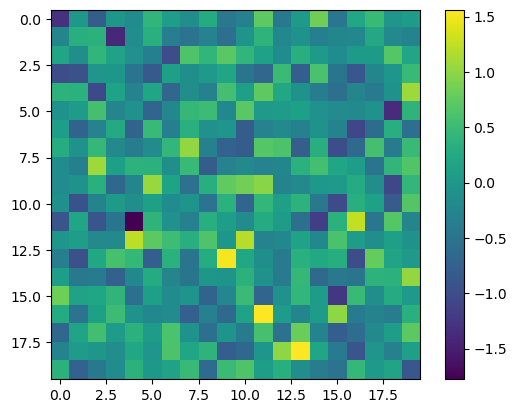

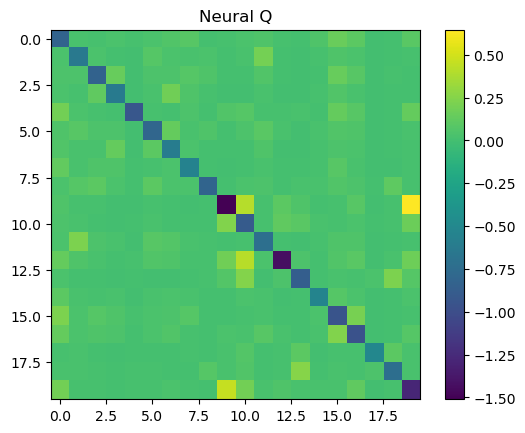

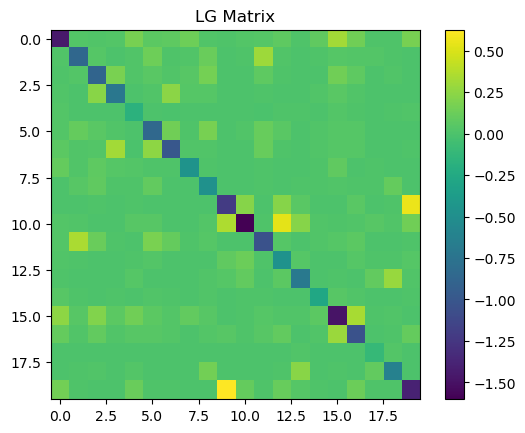

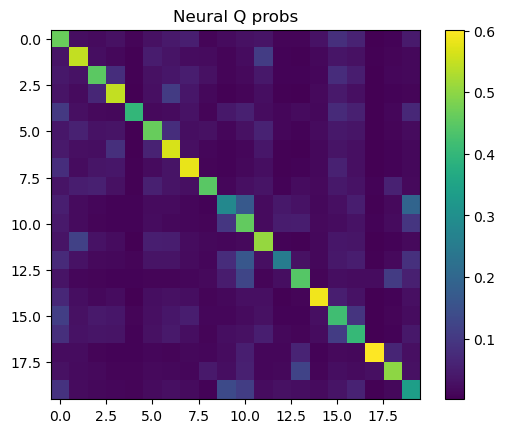

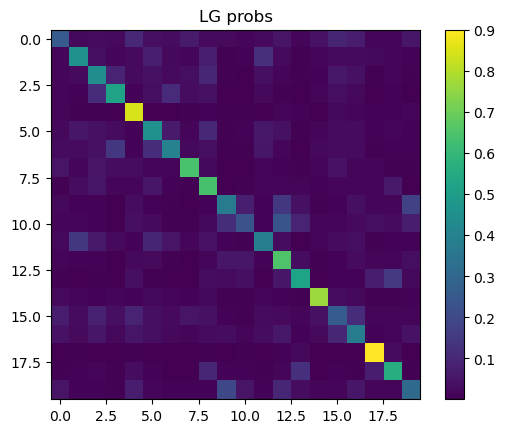

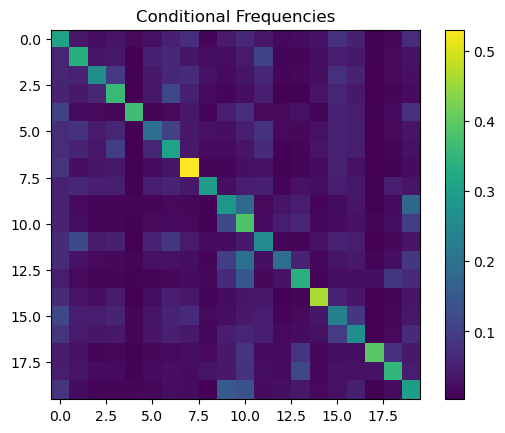

In [112]:
plt.imshow(model.Qp.detach())
plt.colorbar()
plt.show()
    
plt.imshow(Q.mean(dim=0).detach())
plt.colorbar()
plt.title("Neural Q")
plt.show()

plt.imshow(Q_norm.detach())
plt.colorbar()
plt.title("LG Matrix")
plt.show()

plt.imshow(torch.matrix_exp(Q.mean(dim=0).detach()))
plt.colorbar()
plt.title("Neural Q probs")
plt.show()

plt.imshow(torch.matrix_exp(Q_norm).detach())
plt.colorbar()
plt.title("LG probs")
plt.show()

plt.imshow(FREQ)
plt.colorbar()
plt.title("Conditional Frequencies")
plt.show()

In [96]:
torch.set_printoptions(threshold=5)
t.detach()

tensor([[0.7816],
        [0.6830],
        [0.6771],
        ...,
        [2.4487],
        [0.8619],
        [3.0097]])

In [102]:

R_str = """0.425093
0.276818 0.751878
0.395144 0.123954 5.076149
2.489084 0.534551 0.528768 0.062556
0.969894 2.807908 1.695752 0.523386 0.084808
1.038545 0.363970 0.541712 5.243870 0.003499 4.128591
2.066040 0.390192 1.437645 0.844926 0.569265 0.267959 0.348847
0.358858 2.426601 4.509238 0.927114 0.640543 4.813505 0.423881 0.311484
0.149830 0.126991 0.191503 0.010690 0.320627 0.072854 0.044265 0.008705 0.108882
0.395337 0.301848 0.068427 0.015076 0.594007 0.582457 0.069673 0.044261 0.366317 4.145067
0.536518 6.326067 2.145078 0.282959 0.013266 3.234294 1.807177 0.296636 0.697264 0.159069 0.137500
1.124035 0.484133 0.371004 0.025548 0.893680 1.672569 0.173735 0.139538 0.442472 4.273607 6.312358 0.656604
0.253701 0.052722 0.089525 0.017416 1.105251 0.035855 0.018811 0.089586 0.682139 1.112727 2.592692 0.023918 1.798853
1.177651 0.332533 0.161787 0.394456 0.075382 0.624294 0.419409 0.196961 0.508851 0.078281 0.249060 0.390322 0.099849 0.094464
4.727182 0.858151 4.008358 1.240275 2.784478 1.223828 0.611973 1.739990 0.990012 0.064105 0.182287 0.748683 0.346960 0.361819 1.338132
2.139501 0.578987 2.000679 0.425860 1.143480 1.080136 0.604545 0.129836 0.584262 1.033739 0.302936 1.136863 2.020366 0.165001 0.571468 6.472279
0.180717 0.593607 0.045376 0.029890 0.670128 0.236199 0.077852 0.268491 0.597054 0.111660 0.619632 0.049906 0.696175 2.457121 0.095131 0.248862 0.140825
0.218959 0.314440 0.612025 0.135107 1.165532 0.257336 0.120037 0.054679 5.306834 0.232523 0.299648 0.131932 0.481306 7.803902 0.089613 0.400547 0.245841 3.151815
2.547870 0.170887 0.083688 0.037967 1.959291 0.210332 0.245034 0.076701 0.119013 10.649107 1.702745 0.185202 1.898718 0.654683 0.296501 0.098369 2.188158 0.189510 0.249313
"""

PI_str = """0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147"""

PI = torch.tensor(list(map(float,PI_str.split(' '))))

R = torch.zeros(20,20)
i = 0
for line in R_str.splitlines():
    i += 1
    l = list(map(float,line.split(' ')))
    for j in range(i):
        R[i,j] += l[j]
        R[j,i] += l[j]

mu = 0
Q = torch.zeros(20,20)
for i in range(20):
    for j in range(i+1,20):
        Q[i,j] = PI[i]*R[i,j]
        Q[j,i] = PI[j]*R[j,i]
        
    Q[i,i] = -torch.sum(Q[i])
    mu -= PI[i] * Q[i,i]
Q_norm = Q/mu

In [103]:
Q_norm.shape

torch.Size([20, 20])

In [114]:
torch.diagonal(model.Qp)

tensor([-1.2954,  0.3282,  0.4218,  ..., -0.2064, -0.3163, -0.8729],
       grad_fn=<DiagonalBackward0>)

In [118]:
Q_tmp = F.softplus(model.Qp.unsqueeze(0)) #so that every element of Q is >=0
        
PI = torch.diagonal(Q_tmp,dim1=-2,dim2=-1).clone() #makes a copy of the diagonal
PI = F.normalize(PI,p=1,dim=1)  # and normalize it to make probabilities

#pointer manipulation
tmp = torch.diagonal(Q_tmp,dim1=-2,dim2=-1) 
tmp -= tmp #set Q diagonal to 0
tmp -= torch.sum(Q_tmp,dim=2) #sum over rows = 0

mu_tmp = -(PI*torch.diagonal(Q_tmp,dim1=-2,dim2=-1)).sum(dim=1).view(-1,1,1) #normalization factor
Q_tmp = Q_tmp/mu_tmp
Q_tmp = Q_tmp[0]

In [119]:
Q_tmp.shape

torch.Size([20, 20])

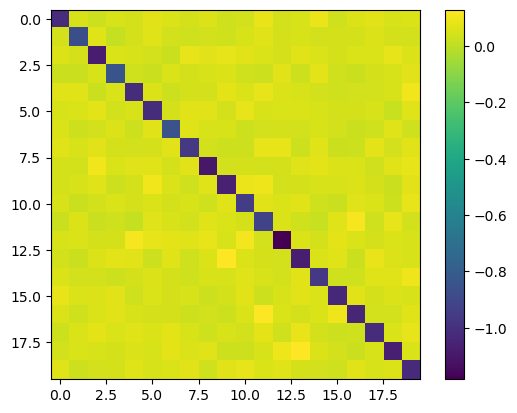

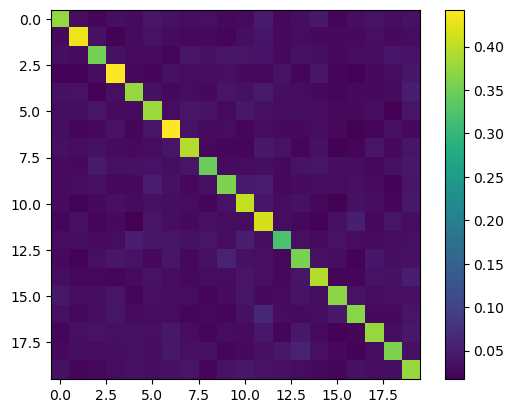

In [132]:
plt.imshow(Q_tmp.detach())
plt.colorbar()
plt.show()

plt.imshow(torch.matrix_exp(Q_tmp).detach())
plt.colorbar()
plt.show()

In [134]:
torch.matrix_exp(Q_norm).detach().mean()

tensor(0.0500)